In [0]:
from fastai.vision import *

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**connect gdrive**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# **make directory data/image**

In [0]:
mkdir data

In [0]:
mkdir data/image

moving image dataset to data/image

In [0]:
mv 'gdrive/My Drive/ieee/images.rar' data/image

using unrar tool to extract rar file

In [0]:
cd data/image

/content/data/image


In [0]:
!unrar e -r images.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from images.rar

Extracting  1001524.jpg                                                    0%  OK 
Extracting  1001804.jpg                                                    0%  OK 
Extracting  1003035.jpg                                                    0%  OK 
Extracting  1004028.jpg                                                    0%  OK 
Extracting  1004054.jpg                                                    0%  OK 
Extracting  1005343.jpg                                                    0%  OK 
Extracting  1007700.jpg                                                    0%  OK 
Extracting  1008439.jpg                                                    0%  OK 
Extracting  1010906.jpg                                                    0%  OK 
Extracting  1011369.jpg                                                  

upload train,test csv files

In [0]:
cd ..

/content


In [0]:
mv train.csv data/image

In [0]:
mv test.csv data/image

In [0]:
df = pd.read_csv('data/image/train.csv')
df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv('data/image', 'train.csv')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

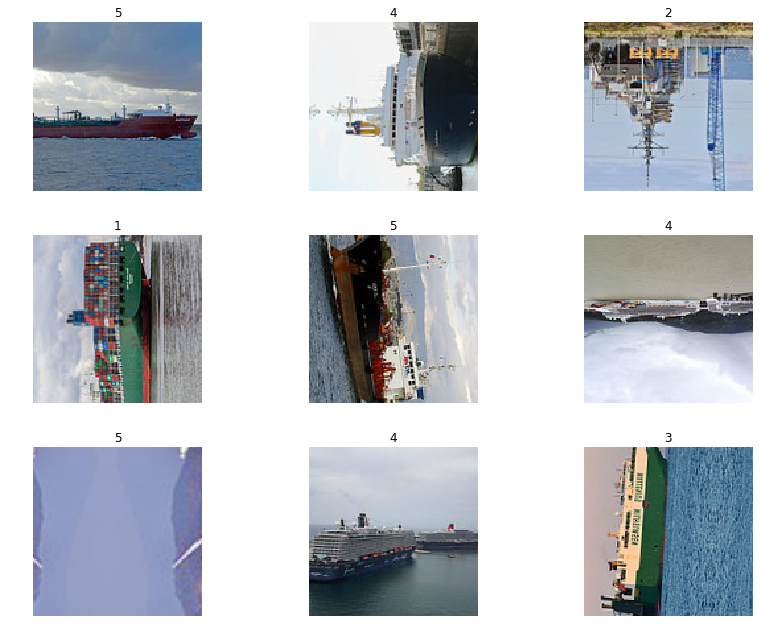

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
print(data.classes)
len(data.classes),data.c

['1', '2', '3', '4', '5']


(5, 5)

In [0]:
data.label_list

LabelLists;

Train: LabelList (5002 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
1,1,2,3,2
Path: data/image;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
4,1,1,3,4
Path: data/image;

Test: None

In [0]:
arch = models.resnet50


In [0]:

f_score = partial(fbeta, thresh=0.5)
learn = cnn_learner(data, arch, metrics=[f_score])

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


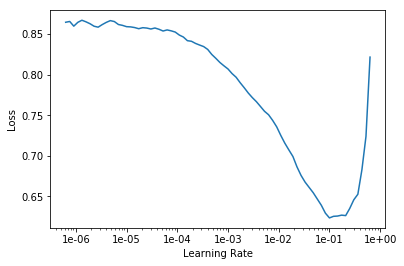

In [0]:
learn.recorder.plot()

In [0]:
lr=0.01

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta,time
0,0.378672,0.173208,0.822267,01:45
1,0.210031,0.127761,0.836800,01:45
2,0.157548,0.114182,0.851200,01:45
3,0.126505,0.104483,0.873600,01:45
4,0.107794,0.103977,0.879200,01:45


In [0]:
learn.save('stage-1-rn50')

fine tuning the model

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


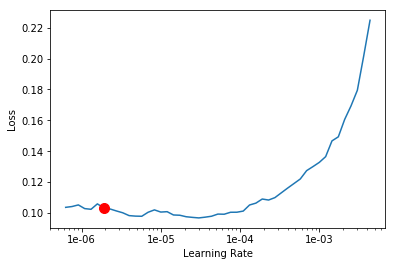

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,fbeta,time
0,0.102379,0.120767,0.856000,02:17
1,0.109657,0.110053,0.879067,02:18
2,0.090206,0.087097,0.909600,02:17
3,0.067366,0.086170,0.911600,02:18
4,0.050339,0.076519,0.919467,02:17


In [0]:
learn.save('stage-2-rn50')

changing the image size to 256

In [0]:
data = (src.transform(tfms, size=256).databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


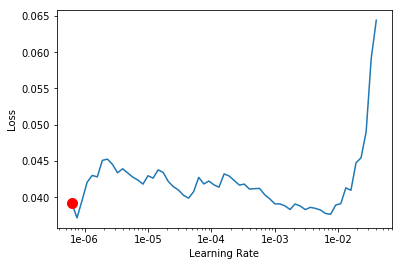

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
lr=1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,fbeta,time
0,0.046716,0.084663,0.911200,02:17
1,0.057406,0.093394,0.908400,02:18
2,0.051476,0.084043,0.915867,02:18
3,0.040157,0.074644,0.932400,02:18
4,0.031782,0.069462,0.937333,02:18


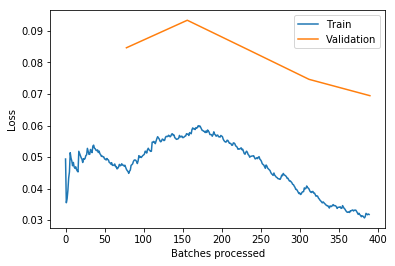

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

In [0]:
learn.export()

# testing(submission.csv generation)

In [0]:
test = ImageList.from_csv('data/image', 'test.csv')
len(test)

2680

In [0]:
learn = load_learner("data/image", test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
max(preds[9])

tensor(0.9272)

In [0]:
labelled_preds[15]

'2 5'

In [0]:
fnames = [f[11:] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image':fnames, 'category':labelled_preds}, columns=['image', 'category'])

In [0]:
df.head()

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


In [0]:
df.to_csv('data/image/submission.csv', index=False)

In [0]:
mv data/image/submission.csv data